<a href="https://colab.research.google.com/github/JiayuTian525/3D---Web-XR/blob/main/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload files and unzip

In [1]:
!unzip /200camera.zip

Archive:  /200camera.zip
   creating: 200camera/
  inflating: 200camera/c33.png       
  inflating: __MACOSX/200camera/._c33.png  
  inflating: 200camera/c27.png       
  inflating: __MACOSX/200camera/._c27.png  
  inflating: 200camera/c8.png        
  inflating: __MACOSX/200camera/._c8.png  
  inflating: 200camera/c190.png      
  inflating: __MACOSX/200camera/._c190.png  
  inflating: 200camera/c184.png      
  inflating: __MACOSX/200camera/._c184.png  
  inflating: 200camera/c153.png      
  inflating: __MACOSX/200camera/._c153.png  
  inflating: 200camera/c147.png      
  inflating: __MACOSX/200camera/._c147.png  
  inflating: 200camera/c146.png      
  inflating: __MACOSX/200camera/._c146.png  
  inflating: 200camera/c152.png      
  inflating: __MACOSX/200camera/._c152.png  
  inflating: 200camera/c185.png      
  inflating: __MACOSX/200camera/._c185.png  
  inflating: 200camera/c191.png      
  inflating: __MACOSX/200camera/._c191.png  
  inflating: 200camera/c9.png        
  in

In [2]:
!unzip /200eye.zip

Archive:  /200eye.zip
   creating: 200eye/
  inflating: 200eye/c33.png          
  inflating: __MACOSX/200eye/._c33.png  
  inflating: 200eye/c27.png          
  inflating: __MACOSX/200eye/._c27.png  
  inflating: 200eye/c8.png           
  inflating: __MACOSX/200eye/._c8.png  
  inflating: 200eye/c190.png         
  inflating: __MACOSX/200eye/._c190.png  
  inflating: 200eye/c184.png         
  inflating: __MACOSX/200eye/._c184.png  
  inflating: 200eye/c153.png         
  inflating: __MACOSX/200eye/._c153.png  
  inflating: 200eye/c147.png         
  inflating: __MACOSX/200eye/._c147.png  
  inflating: 200eye/c146.png         
  inflating: __MACOSX/200eye/._c146.png  
  inflating: 200eye/c152.png         
  inflating: __MACOSX/200eye/._c152.png  
  inflating: 200eye/c185.png         
  inflating: __MACOSX/200eye/._c185.png  
  inflating: 200eye/c191.png         
  inflating: __MACOSX/200eye/._c191.png  
  inflating: 200eye/c9.png           
  inflating: __MACOSX/200eye/._c9.png  
  i

## Set up input, target, paired datasets :


In [3]:
import os

target_path = '/content/200eye'
source_path = '/content/200camera' 
dataset_path = '/content/trans'

is_input_pix_to_pix = False
input_target_index = 1

## Load the images :

In [4]:
# Importing the required Python libraries
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import cv2
from tensorflow.keras.preprocessing import image
import glob
from tqdm.auto import tqdm

# Define a function that loads an image from a given path
def load_image(path):
    size = (256, 256)
    if is_input_pix_to_pix: # In case we are already loading a pix2pix image
        size = (256, 512)
    img = image.load_img(path, target_size=size)
    img = image.img_to_array(img)
    # If we are loading a pix2pix dataset just extract the target
    if is_input_pix_to_pix:
        if input_target_index==0:
            img = img[:,:size[0],:]
        else:
            img = img[:,size[0]:,:]
    return img.astype(np.uint8)

# Define a function that loads all image files from the specified path and returns an array of images
def load_images_in_path(path):
    files = glob.glob(path + '/*')
    images = []
    for imgfile in tqdm(files): #, desc='Loading images in ' + path):
        img = load_image(imgfile)
        images.append(img)
    return images

# The load_images_in_path function is called to load the target images and store them in the target_images variable. 
#Then output the number of loaded target images
target_images = load_images_in_path(target_path)
print('Loaded %d target images'%(len(target_images)))

# If source_path exists, the load_images_in_path function is called to load the source images and store them in the source_images variable. 
#The number of source images loaded is then output
if source_path:
    source_images = load_images_in_path(source_path)
    print('Loaded %d source images'%(len(source_images)))

  0%|          | 0/200 [00:00<?, ?it/s]

Loaded 200 target images


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded 200 source images


## Defining image transformation functions :

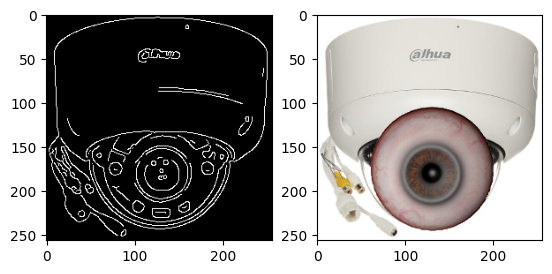

In [8]:
# 这段代码定义了几个函数和一个图片转换函数，并使用matplotlib库显示图片

# 从skimage库中导入边缘检测和滤波器函数
from skimage import feature, filters

# 定义使用cv2库进行边缘检测的函数
def apply_canny_cv2(index, img, thresh1=160, thresh2=250):
    import cv2
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(grayimg, thresh1, thresh2)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

# 定义使用skimage库进行边缘检测的函数
def apply_canny_skimage(index, img, sigma=1.5):
    import cv2
    from skimage import feature
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

# 定义使用mlxtend库提取脸部特征并绘制轮廓的函数
def apply_face_landmarks(index, img, stroke_weight=2):
    from py5canvas import canvas
    from mlxtend.image import extract_face_landmarks

    def landmark_polylines(landmarks):
        # https://pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
        landmarks = np.array(landmarks).astype(np.float32)
        indices = [list(range(0, 17)),
                list(range(17, 22)),
                list(range(22, 27)),
                list(range(27, 31)),
                list(range(31, 36)),
                list(range(36, 42)) + [36],
                list(range(42, 48)) + [42],
                list(range(48, 60)) + [48],
                list(range(60, 68)) + [60]]
        return [landmarks[I] for I in indices]


    c = canvas.Canvas(256, 256)
    c.background(0)
    landmarks = extract_face_landmarks(img)
    if landmarks is None:
        return None
    c.stroke_weight(stroke_weight)
    c.no_fill()
    c.stroke(255)
    paths = landmark_polylines(landmarks)
    for path in paths:
        c.polyline(path)
    return c.get_image()

# 定义图片转换函数
def load_transformed(index, img, transform=apply_canny_skimage):
    if transform is not None:
        return transform(index, source_images[index])
    return source_images[index]

# Set this to your tranformation 设置图片转换函数为 load_transformed
image_transformation = load_transformed

# 选择一张目标图像，作为转换前的图像
img = target_images[0]
# 创建一个新的matplotlib窗口
plt.figure()
# 将该窗口分成1行2列，设置当前操作子图为第1个子图
plt.subplot(1, 2, 1)
# 将转换后的图像显示在第1个子图上
plt.imshow(image_transformation(0, img))
# 将该窗口分成1行2列，设置当前操作子图为第2个子图
plt.subplot(1, 2, 2)
# 将转换前的图像显示在第2个子图上
plt.imshow(img)
# 显示matplotlib窗口
plt.show()

## Create the dataset :

In [9]:
# 导入 Python 内置的 random 模块，用于生成随机数
import random
# 导入 tqdm 模块中的 tqdm 函数，用于显示循环进度条
from tqdm import tqdm
# 用于读取和保存图像数据
from skimage import io

# 设置目标图像索引为 1，表示合成图像中目标图像在左边
target_index = 1
# 设置合成图像数量为 200
num_images = 200
# 设置是否打乱图像顺序为 True，即打乱
shuffle = True
# 生成一个包含所有目标图像索引的列表
image_indices = list(range(len(target_images)))
# 如果需要打乱图像顺序，则执行下一行代码
if shuffle:
    random.shuffle(image_indices)
if num_images != 0:
    image_indices = image_indices[:num_images]

os.makedirs(dataset_path, exist_ok=True)

# 代码创建了一个目录，用于保存生成的图像数据集
index = 1
for i in tqdm(image_indices, desc='Saving dataset to ' + dataset_path):
    target = target_images[i]
#     生成转换后的源图像，然后将源图像与目标图像组合起来
    source = image_transformation(i, target)
    if source is None:
        print('Failed to transform image %d of %d'%(i+1, len(image_indices)))

#         将组合后的图像保存到数据集目录中，并递增index以生成不同的文件名
    if target_index==1:
        combined = np.hstack([source, target])
    else:
        combined = np.hstack([target, source])
    io.imsave(os.path.join(dataset_path, '%d.png'%(index)), combined)
    index += 1

Saving dataset to /content/trans: 100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


## Pix2Pix training :

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display # we will use this to clear the results
import numpy as np
import matplotlib.pyplot as plt
import os, sys

## Load and preprocess dataset :

Defines variables for dataset path, number of image channels, image size and batch size

In [11]:
dataset_path = "/content/trans" # Change this for your custom dataset
img_channels = 3
img_size = 256
batch_size = 1

Found 200 files belonging to 1 classes.


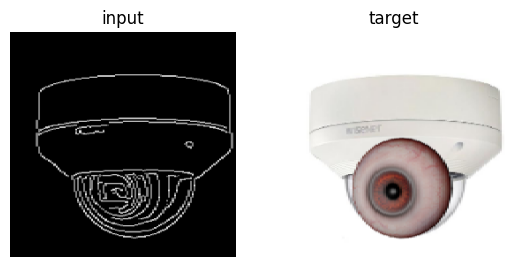

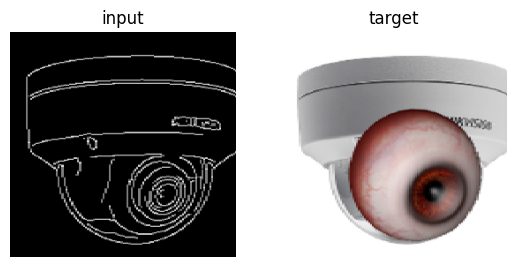

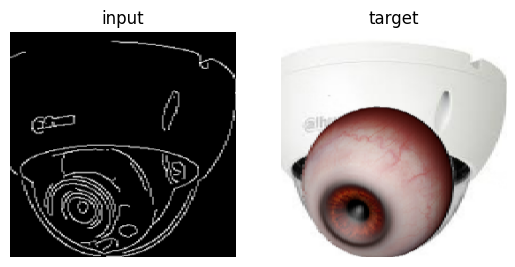

In [12]:
target_index = 1

# 将输入图片和目标图片调整为指定的尺寸

def resize(input_image, target_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  target_image = tf.image.resize(target_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, target_image

# 对输入图片和目标图片进行随机裁剪

def random_crop(input_image, target_image):
  stacked_image = tf.stack([input_image, target_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, 256, 256, 3])

  return cropped_image[0], cropped_image[1]


@tf.function()

# 输入图片和目标图片进行随机操作，包括将图片尺寸调整为 286x286、随机裁剪到 256x256、随机翻转等
def random_jitter(input_image, target_image):
  # Resizing to 286x286
  input_image, target_image = resize(input_image, target_image, 286, 286)

  # Random cropping back to 256x256
  input_image, target_image = random_crop(input_image, target_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    target_image = tf.image.flip_left_right(target_image)

  return input_image, target_image


# 对每张图片进行预处理，将其拆分成输入图片和目标图片，然后对它们进行随机操作和归一化
def preprocess_image(image):
    # Split each image tensor into two tensors:
    w = tf.shape(image)[1]
    w = w // 2

    if target_index==0:
        input_image = image[:, w:, :]
        target_image = image[:, :w, :]
    else:
        target_image = image[:, w:, :]
        input_image = image[:, :w, :]
    # Jitter
    input_image, target_image = random_jitter(input_image, target_image)
    # Normalize
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image


# 从指定目录加载图片数据集
dataset = keras.utils.image_dataset_from_directory(
    dataset_path, label_mode=None, image_size=(img_size*2, img_size), batch_size=None)

# 对数据集中的每张图片进行预处理
dataset = dataset.map(preprocess_image) 
dataset = dataset.batch(batch_size)

# 数据集拆分为一个一个 batch 并进行可视化展示，展示了每个 batch 中第一张图片的输入和目标
for i, (input_img, output_img) in enumerate(dataset):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('input')
    plt.imshow((input_img.numpy() * 127.5 + 127.5).astype("int32")[0])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('target')
    plt.imshow((output_img.numpy() * 127.5 + 127.5).astype("int32")[0])
    plt.axis('off')
    plt.show()
    if i==2:
        break

## Build the model :

## Generator :

In [13]:
# 用于构建模型中的下采样层，即对输入的图像进行降采样操作，将图像分辨率减小一半
def downsample(filters, size, apply_batchnorm=True):
    init = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=init, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


# 用于构建模型中的上采样层，即对输入的图像进行升采样操作，将图像分辨率增加一倍
def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=init,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


# 用于构建整个生成器模型
def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
#   生成器模型的最后一层是一个转置卷积层，用于将生成的图像映射到原始图像的分辨率
#   并使用 tanh 激活函数将像素值归一化到 [-1,1] 的范围内
    last = tf.keras.layers.Conv2DTranspose(img_channels, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')  # (batch_size, 256, 256, 3)
#     代表模型的输入，即一个形状为 [256, 256, 3] 的张量，表示输入图像的尺寸为 256x256，并具有 3 个通道

    x = inputs

    # Downsampling through the model
    # 用于存储每个下采样层的输出
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = build_generator()

# 输出生成器模型的概览信息，包括每一层的名称、输出形状等
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

## Discriminator :

In [14]:
# 用来构建鉴别器，是image translation任务中的一部分，用于判别生成的图像和真实图像的差异
def build_discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=init,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=init)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

## Generate some images before training :

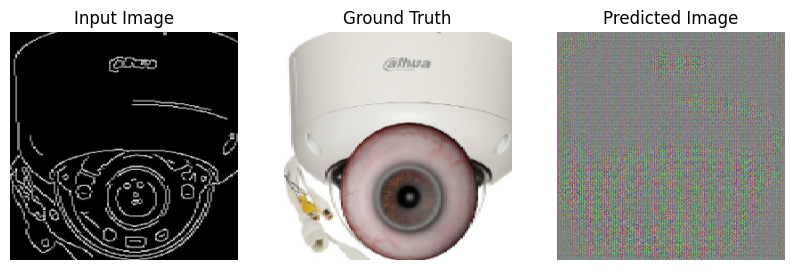

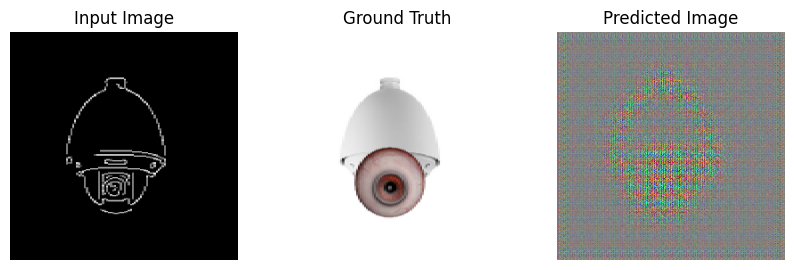

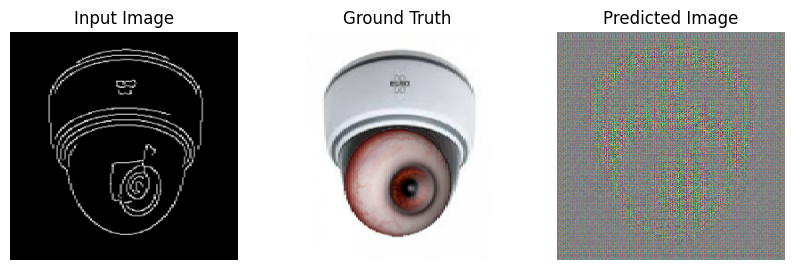

In [15]:
# 定义了一个名为generate_images的函数，用于显示模型生成的图像
def generate_images(model, test_input, tar, fname=''):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10, 10))


    if tar is not None:
        display_list = [test_input[0], tar[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
    else:
        display_list = [test_input[0], prediction[0]]
        title = ['Input Image', 'Predicted Image']

    for i in range(len(title)):
        plt.subplot(1, len(title), i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    if fname:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show()

for example_input, example_target in dataset.take(3):
    generate_images(generator, example_input, example_target)

## Training the model :

## Generator loss :

In [16]:
# 定义了生成器的损失函数
LAMBDA = 100 #常数，用于控制生成器中 L1 loss 对 GAN loss 的相对权重
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Discriminator loss :

In [17]:
# 定义了一个计算判别器损失的函数
# 在这个GAN网络中，判别器的目标是将真实数据的判别器输出接近1，生成器生成数据的判别器输出接近0
# 因此，真实数据的判别器损失应该趋近于0，生成器生成数据的判别器损失应该趋近于1
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

## Training loop :

In [ ]:
# 这些代码是用于训练一个图像生成器的，它将一个输入图像转换为一个目标图像，使其看起来像是目标图像
# 这个生成器是用卷积神经网络实现的，它通过学习从输入图像到目标图像的映射来实现这一目标

epochs = 100 #训练循环将运行100次
save_interval = 1 # 试试不同的值，每次训练一个epoch后，将保存一些生成的图像和模型文件，以及一个损失的可视化图，这个参数指定保存的间隔

model_path = "/content/model" # 生成的图像和模型文件将保存在这个目录中
os.makedirs(model_path, exist_ok=True) # 如果该目录不存在，则会被创建

# 使用Adam优化器来优化生成器的权重参数
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# 使用Adam优化器来优化判别器的权重参数
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# 装饰器。使得函数可以在TensorFlow的计算图中被编译和优化，提高了代码的运行效率
@tf.function

# 训练一个批次的数据，这个函数包含了生成器和判别器的训练代码，计算了损失，并进行了梯度更新
def train_step(batch):
    input_image, target = batch
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                    discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

g_losses = []
d_losses = []


# 循环训练每一个epoch
for epoch in range(epochs):
    #获取整个数据集的批次数
    n = dataset.cardinality() # The number of batches per epoch
    # Iterate over all batches
    batch_d_losses = []
    batch_g_losses = []
    
    #循环训练数据集的每一个批次
    for i, batch in enumerate(dataset):
        # Updte parameters for this batch
        gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(batch)

        # Store losses for batch, we will average these for the whole epoch for a more stable visualization
        batch_d_losses.append(disc_loss)
        batch_g_losses.append(gen_total_loss)
        
        #在控制台输出训练进度和损失
        sys.stdout.write("\r" + "Epoch %d - image %d of %d "%(epoch+1, i+1, n) + "[gen total loss: "+str(gen_total_loss)+ " | disc loss: "+str(disc_loss)+"]")

    # Book-keeping:
    # Visualize losses and one example image for the epoch
    g_losses.append(np.mean(batch_g_losses))
    d_losses.append(np.mean(batch_d_losses))

    #清除输出，以便在每次循环时重新绘制损失可视化图
    display.clear_output(wait=True)
    plt.figure(figsize=(6,5))
    plt.title('Losses')
    #绘制损失可视化图
    plt.plot(np.array(d_losses)*40, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()
    plt.savefig(os.path.join(model_path, "losses.pdf"))
    plt.close()

    # Save some example images and store model file
    if epoch % save_interval == 0:
        print('Saving epoch %d to %s'%(epoch+1, model_path))
        for j, (example_input, example_target) in enumerate(dataset.take(3)):
            #生成一些样本图像，用于可视化和保存
            generate_images(generator, example_input, example_target,
                            fname=os.path.join(model_path, "e%03d_generated_image_%d.png" % (epoch+1, j+1)))
            #保存生成器的权重参数到一个HDF5文件中
        generator.save(os.path.join(model_path, "e%0d_generator.hd5"%(epoch+1)), save_format='h5')

Epoch 1 - image 200 of 200 [gen total loss: tf.Tensor(27.90179, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5711801, shape=(), dtype=float32)]Saving epoch 1 to /content/model


Epoch 2 - image 200 of 200 [gen total loss: tf.Tensor(17.509716, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5995928, shape=(), dtype=float32)]Saving epoch 2 to /content/model


Epoch 3 - image 200 of 200 [gen total loss: tf.Tensor(19.831322, shape=(), dtype=float32) | disc loss: tf.Tensor(1.0210763, shape=(), dtype=float32)]Saving epoch 3 to /content/model


Epoch 4 - image 200 of 200 [gen total loss: tf.Tensor(22.124718, shape=(), dtype=float32) | disc loss: tf.Tensor(1.1544867, shape=(), dtype=float32)]Saving epoch 4 to /content/model


Epoch 5 - image 200 of 200 [gen total loss: tf.Tensor(29.09686, shape=(), dtype=float32) | disc loss: tf.Tensor(0.29139608, shape=(), dtype=float32)]Saving epoch 5 to /content/model


Epoch 6 - image 200 of 200 [gen total loss: tf.Tensor(24.500834, shape=(), dtype=float32) | disc loss: tf.Tensor(0.4780522, shape=(), dtype=float32)]Saving epoch 6 to /content/model


Epoch 7 - image 200 of 200 [gen total loss: tf.Tensor(14.344463, shape=(), dtype=float32) | disc loss: tf.Tensor(0.6011573, shape=(), dtype=float32)]Saving epoch 7 to /content/model


Epoch 8 - image 200 of 200 [gen total loss: tf.Tensor(26.092024, shape=(), dtype=float32) | disc loss: tf.Tensor(0.8064001, shape=(), dtype=float32)]Saving epoch 8 to /content/model


Epoch 9 - image 200 of 200 [gen total loss: tf.Tensor(25.722446, shape=(), dtype=float32) | disc loss: tf.Tensor(0.82051384, shape=(), dtype=float32)]Saving epoch 9 to /content/model


Epoch 10 - image 200 of 200 [gen total loss: tf.Tensor(29.561651, shape=(), dtype=float32) | disc loss: tf.Tensor(0.45199254, shape=(), dtype=float32)]Saving epoch 10 to /content/model


Epoch 11 - image 200 of 200 [gen total loss: tf.Tensor(8.476245, shape=(), dtype=float32) | disc loss: tf.Tensor(0.8267293, shape=(), dtype=float32)]Saving epoch 11 to /content/model


Epoch 12 - image 200 of 200 [gen total loss: tf.Tensor(20.411545, shape=(), dtype=float32) | disc loss: tf.Tensor(0.9224038, shape=(), dtype=float32)]Saving epoch 12 to /content/model


Epoch 13 - image 200 of 200 [gen total loss: tf.Tensor(34.496136, shape=(), dtype=float32) | disc loss: tf.Tensor(0.36340597, shape=(), dtype=float32)]Saving epoch 13 to /content/model


Epoch 14 - image 200 of 200 [gen total loss: tf.Tensor(16.508448, shape=(), dtype=float32) | disc loss: tf.Tensor(1.0022008, shape=(), dtype=float32)]Saving epoch 14 to /content/model


Epoch 15 - image 200 of 200 [gen total loss: tf.Tensor(13.486987, shape=(), dtype=float32) | disc loss: tf.Tensor(0.82839423, shape=(), dtype=float32)]Saving epoch 15 to /content/model


Epoch 16 - image 200 of 200 [gen total loss: tf.Tensor(24.589449, shape=(), dtype=float32) | disc loss: tf.Tensor(0.30638736, shape=(), dtype=float32)]Saving epoch 16 to /content/model


Epoch 17 - image 200 of 200 [gen total loss: tf.Tensor(20.881813, shape=(), dtype=float32) | disc loss: tf.Tensor(0.73354685, shape=(), dtype=float32)]Saving epoch 17 to /content/model


Epoch 18 - image 200 of 200 [gen total loss: tf.Tensor(13.55484, shape=(), dtype=float32) | disc loss: tf.Tensor(2.0289297, shape=(), dtype=float32)]Saving epoch 18 to /content/model


Epoch 19 - image 200 of 200 [gen total loss: tf.Tensor(17.756035, shape=(), dtype=float32) | disc loss: tf.Tensor(0.55345446, shape=(), dtype=float32)]Saving epoch 19 to /content/model


Epoch 20 - image 200 of 200 [gen total loss: tf.Tensor(17.368412, shape=(), dtype=float32) | disc loss: tf.Tensor(1.4587102, shape=(), dtype=float32)]Saving epoch 20 to /content/model


Epoch 21 - image 200 of 200 [gen total loss: tf.Tensor(18.338896, shape=(), dtype=float32) | disc loss: tf.Tensor(0.56846595, shape=(), dtype=float32)]Saving epoch 21 to /content/model


Epoch 22 - image 200 of 200 [gen total loss: tf.Tensor(17.640028, shape=(), dtype=float32) | disc loss: tf.Tensor(0.874333, shape=(), dtype=float32)]Saving epoch 22 to /content/model


Epoch 23 - image 200 of 200 [gen total loss: tf.Tensor(26.58005, shape=(), dtype=float32) | disc loss: tf.Tensor(0.55787873, shape=(), dtype=float32)]Saving epoch 23 to /content/model


Epoch 24 - image 200 of 200 [gen total loss: tf.Tensor(22.419722, shape=(), dtype=float32) | disc loss: tf.Tensor(0.65854836, shape=(), dtype=float32)]Saving epoch 24 to /content/model


Epoch 25 - image 200 of 200 [gen total loss: tf.Tensor(9.91807, shape=(), dtype=float32) | disc loss: tf.Tensor(1.0945394, shape=(), dtype=float32)]Saving epoch 25 to /content/model


Epoch 26 - image 200 of 200 [gen total loss: tf.Tensor(22.247385, shape=(), dtype=float32) | disc loss: tf.Tensor(0.18612935, shape=(), dtype=float32)]Saving epoch 26 to /content/model


Epoch 27 - image 200 of 200 [gen total loss: tf.Tensor(22.584126, shape=(), dtype=float32) | disc loss: tf.Tensor(0.68172276, shape=(), dtype=float32)]Saving epoch 27 to /content/model


Epoch 28 - image 200 of 200 [gen total loss: tf.Tensor(16.129847, shape=(), dtype=float32) | disc loss: tf.Tensor(0.62335026, shape=(), dtype=float32)]Saving epoch 28 to /content/model


Epoch 29 - image 200 of 200 [gen total loss: tf.Tensor(10.605701, shape=(), dtype=float32) | disc loss: tf.Tensor(1.3602159, shape=(), dtype=float32)]Saving epoch 29 to /content/model


Epoch 30 - image 200 of 200 [gen total loss: tf.Tensor(32.81882, shape=(), dtype=float32) | disc loss: tf.Tensor(0.51814127, shape=(), dtype=float32)]Saving epoch 30 to /content/model


Epoch 31 - image 200 of 200 [gen total loss: tf.Tensor(20.027847, shape=(), dtype=float32) | disc loss: tf.Tensor(0.9135474, shape=(), dtype=float32)]Saving epoch 31 to /content/model


Epoch 32 - image 200 of 200 [gen total loss: tf.Tensor(10.608303, shape=(), dtype=float32) | disc loss: tf.Tensor(0.46853507, shape=(), dtype=float32)]Saving epoch 32 to /content/model


Epoch 33 - image 200 of 200 [gen total loss: tf.Tensor(19.590536, shape=(), dtype=float32) | disc loss: tf.Tensor(0.4665143, shape=(), dtype=float32)]Saving epoch 33 to /content/model


Epoch 34 - image 200 of 200 [gen total loss: tf.Tensor(7.693617, shape=(), dtype=float32) | disc loss: tf.Tensor(0.9050753, shape=(), dtype=float32)]Saving epoch 34 to /content/model


Epoch 35 - image 200 of 200 [gen total loss: tf.Tensor(22.608183, shape=(), dtype=float32) | disc loss: tf.Tensor(0.27915654, shape=(), dtype=float32)]Saving epoch 35 to /content/model


Epoch 36 - image 200 of 200 [gen total loss: tf.Tensor(11.464264, shape=(), dtype=float32) | disc loss: tf.Tensor(0.60688835, shape=(), dtype=float32)]Saving epoch 36 to /content/model


Epoch 37 - image 200 of 200 [gen total loss: tf.Tensor(8.337721, shape=(), dtype=float32) | disc loss: tf.Tensor(1.1002295, shape=(), dtype=float32)]Saving epoch 37 to /content/model


Epoch 38 - image 200 of 200 [gen total loss: tf.Tensor(16.904636, shape=(), dtype=float32) | disc loss: tf.Tensor(1.1196234, shape=(), dtype=float32)]Saving epoch 38 to /content/model


Epoch 39 - image 200 of 200 [gen total loss: tf.Tensor(20.488192, shape=(), dtype=float32) | disc loss: tf.Tensor(0.38572907, shape=(), dtype=float32)]Saving epoch 39 to /content/model


Epoch 40 - image 200 of 200 [gen total loss: tf.Tensor(21.58971, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5685463, shape=(), dtype=float32)]Saving epoch 40 to /content/model


Epoch 41 - image 200 of 200 [gen total loss: tf.Tensor(23.19716, shape=(), dtype=float32) | disc loss: tf.Tensor(0.34963095, shape=(), dtype=float32)]Saving epoch 41 to /content/model


Epoch 42 - image 200 of 200 [gen total loss: tf.Tensor(9.9205885, shape=(), dtype=float32) | disc loss: tf.Tensor(0.31492698, shape=(), dtype=float32)]Saving epoch 42 to /content/model


Epoch 43 - image 200 of 200 [gen total loss: tf.Tensor(10.311762, shape=(), dtype=float32) | disc loss: tf.Tensor(0.4577516, shape=(), dtype=float32)]Saving epoch 43 to /content/model


Epoch 44 - image 200 of 200 [gen total loss: tf.Tensor(19.679407, shape=(), dtype=float32) | disc loss: tf.Tensor(0.08723922, shape=(), dtype=float32)]Saving epoch 44 to /content/model


Epoch 45 - image 200 of 200 [gen total loss: tf.Tensor(25.063412, shape=(), dtype=float32) | disc loss: tf.Tensor(0.44606885, shape=(), dtype=float32)]Saving epoch 45 to /content/model


Epoch 46 - image 200 of 200 [gen total loss: tf.Tensor(16.11874, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5317583, shape=(), dtype=float32)]Saving epoch 46 to /content/model


Epoch 47 - image 200 of 200 [gen total loss: tf.Tensor(22.947248, shape=(), dtype=float32) | disc loss: tf.Tensor(0.15715338, shape=(), dtype=float32)]Saving epoch 47 to /content/model


Epoch 48 - image 200 of 200 [gen total loss: tf.Tensor(15.271883, shape=(), dtype=float32) | disc loss: tf.Tensor(0.6228168, shape=(), dtype=float32)]Saving epoch 48 to /content/model


Epoch 49 - image 200 of 200 [gen total loss: tf.Tensor(17.181028, shape=(), dtype=float32) | disc loss: tf.Tensor(0.48333323, shape=(), dtype=float32)]Saving epoch 49 to /content/model


Epoch 50 - image 200 of 200 [gen total loss: tf.Tensor(20.27218, shape=(), dtype=float32) | disc loss: tf.Tensor(0.4886314, shape=(), dtype=float32)]Saving epoch 50 to /content/model


Epoch 51 - image 200 of 200 [gen total loss: tf.Tensor(23.701733, shape=(), dtype=float32) | disc loss: tf.Tensor(1.1098728, shape=(), dtype=float32)]Saving epoch 51 to /content/model


Epoch 52 - image 200 of 200 [gen total loss: tf.Tensor(18.708096, shape=(), dtype=float32) | disc loss: tf.Tensor(0.7738317, shape=(), dtype=float32)]Saving epoch 52 to /content/model


Epoch 53 - image 200 of 200 [gen total loss: tf.Tensor(18.861677, shape=(), dtype=float32) | disc loss: tf.Tensor(0.8607752, shape=(), dtype=float32)]Saving epoch 53 to /content/model


Epoch 54 - image 200 of 200 [gen total loss: tf.Tensor(15.838252, shape=(), dtype=float32) | disc loss: tf.Tensor(1.3568813, shape=(), dtype=float32)]Saving epoch 54 to /content/model


Epoch 55 - image 200 of 200 [gen total loss: tf.Tensor(52.378834, shape=(), dtype=float32) | disc loss: tf.Tensor(0.056528077, shape=(), dtype=float32)]Saving epoch 55 to /content/model


Epoch 56 - image 200 of 200 [gen total loss: tf.Tensor(15.82448, shape=(), dtype=float32) | disc loss: tf.Tensor(0.4286477, shape=(), dtype=float32)]Saving epoch 56 to /content/model


Epoch 57 - image 200 of 200 [gen total loss: tf.Tensor(13.36869, shape=(), dtype=float32) | disc loss: tf.Tensor(0.80866367, shape=(), dtype=float32)]Saving epoch 57 to /content/model


Epoch 58 - image 200 of 200 [gen total loss: tf.Tensor(9.817622, shape=(), dtype=float32) | disc loss: tf.Tensor(0.8798703, shape=(), dtype=float32)]Saving epoch 58 to /content/model


Epoch 59 - image 200 of 200 [gen total loss: tf.Tensor(7.25997, shape=(), dtype=float32) | disc loss: tf.Tensor(1.007177, shape=(), dtype=float32)]Saving epoch 59 to /content/model


Epoch 60 - image 200 of 200 [gen total loss: tf.Tensor(15.399593, shape=(), dtype=float32) | disc loss: tf.Tensor(0.41273624, shape=(), dtype=float32)]Saving epoch 60 to /content/model


Epoch 61 - image 200 of 200 [gen total loss: tf.Tensor(18.114893, shape=(), dtype=float32) | disc loss: tf.Tensor(0.30856153, shape=(), dtype=float32)]Saving epoch 61 to /content/model


Epoch 62 - image 200 of 200 [gen total loss: tf.Tensor(6.3977966, shape=(), dtype=float32) | disc loss: tf.Tensor(0.50211245, shape=(), dtype=float32)]Saving epoch 62 to /content/model


Epoch 63 - image 200 of 200 [gen total loss: tf.Tensor(19.217293, shape=(), dtype=float32) | disc loss: tf.Tensor(0.56245893, shape=(), dtype=float32)]Saving epoch 63 to /content/model


Epoch 64 - image 200 of 200 [gen total loss: tf.Tensor(17.254215, shape=(), dtype=float32) | disc loss: tf.Tensor(1.3818816, shape=(), dtype=float32)]Saving epoch 64 to /content/model


Epoch 65 - image 200 of 200 [gen total loss: tf.Tensor(15.086064, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5657884, shape=(), dtype=float32)]Saving epoch 65 to /content/model


Epoch 66 - image 200 of 200 [gen total loss: tf.Tensor(18.640217, shape=(), dtype=float32) | disc loss: tf.Tensor(0.59545255, shape=(), dtype=float32)]Saving epoch 66 to /content/model


Epoch 67 - image 200 of 200 [gen total loss: tf.Tensor(4.520663, shape=(), dtype=float32) | disc loss: tf.Tensor(1.2982771, shape=(), dtype=float32)]Saving epoch 67 to /content/model


Epoch 68 - image 200 of 200 [gen total loss: tf.Tensor(18.440693, shape=(), dtype=float32) | disc loss: tf.Tensor(0.8781347, shape=(), dtype=float32)]Saving epoch 68 to /content/model


Epoch 69 - image 200 of 200 [gen total loss: tf.Tensor(18.017607, shape=(), dtype=float32) | disc loss: tf.Tensor(0.3657806, shape=(), dtype=float32)]Saving epoch 69 to /content/model


Epoch 70 - image 200 of 200 [gen total loss: tf.Tensor(21.242882, shape=(), dtype=float32) | disc loss: tf.Tensor(0.66829616, shape=(), dtype=float32)]Saving epoch 70 to /content/model


Epoch 71 - image 200 of 200 [gen total loss: tf.Tensor(18.584938, shape=(), dtype=float32) | disc loss: tf.Tensor(0.1541743, shape=(), dtype=float32)]Saving epoch 71 to /content/model


Epoch 72 - image 200 of 200 [gen total loss: tf.Tensor(12.414716, shape=(), dtype=float32) | disc loss: tf.Tensor(0.39355594, shape=(), dtype=float32)]Saving epoch 72 to /content/model


Epoch 73 - image 200 of 200 [gen total loss: tf.Tensor(5.9675198, shape=(), dtype=float32) | disc loss: tf.Tensor(0.7192573, shape=(), dtype=float32)]Saving epoch 73 to /content/model


Epoch 74 - image 200 of 200 [gen total loss: tf.Tensor(31.578083, shape=(), dtype=float32) | disc loss: tf.Tensor(0.9288537, shape=(), dtype=float32)]Saving epoch 74 to /content/model


Epoch 75 - image 200 of 200 [gen total loss: tf.Tensor(14.572042, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5211086, shape=(), dtype=float32)]Saving epoch 75 to /content/model


Epoch 76 - image 200 of 200 [gen total loss: tf.Tensor(21.797823, shape=(), dtype=float32) | disc loss: tf.Tensor(0.26052663, shape=(), dtype=float32)]Saving epoch 76 to /content/model


Epoch 77 - image 200 of 200 [gen total loss: tf.Tensor(7.6586003, shape=(), dtype=float32) | disc loss: tf.Tensor(1.6687207, shape=(), dtype=float32)]Saving epoch 77 to /content/model


Epoch 78 - image 200 of 200 [gen total loss: tf.Tensor(23.524647, shape=(), dtype=float32) | disc loss: tf.Tensor(0.3820603, shape=(), dtype=float32)]Saving epoch 78 to /content/model


Epoch 79 - image 200 of 200 [gen total loss: tf.Tensor(20.35787, shape=(), dtype=float32) | disc loss: tf.Tensor(0.16158596, shape=(), dtype=float32)]Saving epoch 79 to /content/model


Epoch 80 - image 200 of 200 [gen total loss: tf.Tensor(18.040564, shape=(), dtype=float32) | disc loss: tf.Tensor(0.835535, shape=(), dtype=float32)]Saving epoch 80 to /content/model


Epoch 81 - image 200 of 200 [gen total loss: tf.Tensor(7.708598, shape=(), dtype=float32) | disc loss: tf.Tensor(0.7486786, shape=(), dtype=float32)]Saving epoch 81 to /content/model


Epoch 82 - image 200 of 200 [gen total loss: tf.Tensor(19.293299, shape=(), dtype=float32) | disc loss: tf.Tensor(2.5226073, shape=(), dtype=float32)]Saving epoch 82 to /content/model


Epoch 83 - image 200 of 200 [gen total loss: tf.Tensor(12.306943, shape=(), dtype=float32) | disc loss: tf.Tensor(0.39793482, shape=(), dtype=float32)]Saving epoch 83 to /content/model


Epoch 84 - image 200 of 200 [gen total loss: tf.Tensor(16.753956, shape=(), dtype=float32) | disc loss: tf.Tensor(2.1158333, shape=(), dtype=float32)]Saving epoch 84 to /content/model


Epoch 85 - image 200 of 200 [gen total loss: tf.Tensor(12.77713, shape=(), dtype=float32) | disc loss: tf.Tensor(0.277543, shape=(), dtype=float32)]Saving epoch 85 to /content/model


Epoch 86 - image 200 of 200 [gen total loss: tf.Tensor(16.633196, shape=(), dtype=float32) | disc loss: tf.Tensor(0.66361547, shape=(), dtype=float32)]Saving epoch 86 to /content/model


Epoch 87 - image 200 of 200 [gen total loss: tf.Tensor(16.263577, shape=(), dtype=float32) | disc loss: tf.Tensor(0.46400088, shape=(), dtype=float32)]Saving epoch 87 to /content/model


Epoch 88 - image 200 of 200 [gen total loss: tf.Tensor(12.9638405, shape=(), dtype=float32) | disc loss: tf.Tensor(0.3725772, shape=(), dtype=float32)]Saving epoch 88 to /content/model


Epoch 89 - image 200 of 200 [gen total loss: tf.Tensor(11.811017, shape=(), dtype=float32) | disc loss: tf.Tensor(1.0025015, shape=(), dtype=float32)]Saving epoch 89 to /content/model


Epoch 90 - image 200 of 200 [gen total loss: tf.Tensor(22.401358, shape=(), dtype=float32) | disc loss: tf.Tensor(0.1424402, shape=(), dtype=float32)]Saving epoch 90 to /content/model


Epoch 91 - image 200 of 200 [gen total loss: tf.Tensor(16.979155, shape=(), dtype=float32) | disc loss: tf.Tensor(0.29184163, shape=(), dtype=float32)]Saving epoch 91 to /content/model


Epoch 92 - image 200 of 200 [gen total loss: tf.Tensor(11.784016, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5399462, shape=(), dtype=float32)]Saving epoch 92 to /content/model


Epoch 93 - image 200 of 200 [gen total loss: tf.Tensor(15.872841, shape=(), dtype=float32) | disc loss: tf.Tensor(0.7130796, shape=(), dtype=float32)]Saving epoch 93 to /content/model


Epoch 94 - image 200 of 200 [gen total loss: tf.Tensor(14.635593, shape=(), dtype=float32) | disc loss: tf.Tensor(0.46974868, shape=(), dtype=float32)]Saving epoch 94 to /content/model


Epoch 95 - image 200 of 200 [gen total loss: tf.Tensor(15.203226, shape=(), dtype=float32) | disc loss: tf.Tensor(1.3568624, shape=(), dtype=float32)]Saving epoch 95 to /content/model


Epoch 96 - image 200 of 200 [gen total loss: tf.Tensor(12.360087, shape=(), dtype=float32) | disc loss: tf.Tensor(0.7430954, shape=(), dtype=float32)]Saving epoch 96 to /content/model


Epoch 97 - image 200 of 200 [gen total loss: tf.Tensor(11.44017, shape=(), dtype=float32) | disc loss: tf.Tensor(0.8433182, shape=(), dtype=float32)]Saving epoch 97 to /content/model


Epoch 98 - image 200 of 200 [gen total loss: tf.Tensor(16.877956, shape=(), dtype=float32) | disc loss: tf.Tensor(0.2552381, shape=(), dtype=float32)]Saving epoch 98 to /content/model


Epoch 99 - image 200 of 200 [gen total loss: tf.Tensor(11.56851, shape=(), dtype=float32) | disc loss: tf.Tensor(0.5221107, shape=(), dtype=float32)]Saving epoch 99 to /content/model


Epoch 100 - image 129 of 200 [gen total loss: tf.Tensor(13.589218, shape=(), dtype=float32) | disc loss: tf.Tensor(0.8295479, shape=(), dtype=float32)]

In [20]:
from google.colab import files
!zip -r trans.zip /content/trans
files.download('trans.zip')

updating: content/trans/ (stored 0%)
updating: content/trans/67.png (deflated 1%)
updating: content/trans/57.png (deflated 1%)
updating: content/trans/121.png (deflated 1%)
updating: content/trans/151.png (deflated 1%)
updating: content/trans/138.png (deflated 1%)
updating: content/trans/45.png (deflated 1%)
updating: content/trans/154.png (deflated 1%)
updating: content/trans/82.png (deflated 3%)
updating: content/trans/112.png (deflated 1%)
updating: content/trans/41.png (deflated 0%)
updating: content/trans/22.png (deflated 1%)
updating: content/trans/14.png (deflated 0%)
updating: content/trans/44.png (deflated 0%)
updating: content/trans/162.png (deflated 0%)
updating: content/trans/158.png (deflated 0%)
updating: content/trans/119.png (deflated 1%)
updating: content/trans/184.png (deflated 2%)
updating: content/trans/56.png (deflated 1%)
updating: content/trans/1.png (deflated 0%)
updating: content/trans/89.png (deflated 1%)
updating: content/trans/136.png (deflated 0%)
updating:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>